In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
import cv2
import albumentations as A
import time
import os

from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
from datasets import load_metric

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device.upper()}" device.')

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

num_classes = 23

Currently using "CUDA" device.


# Read Data

In [2]:
images_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
color_masks_path = r'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/'
masks_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

images = glob(images_path + '*.jpg')
colored_masks = glob(color_masks_path + '*.png')
masks = glob(masks_path + '*.png')

images = sorted([str(p) for p in images])
colored_masks = sorted([str(p) for p in colored_masks])
masks = sorted([str(p) for p in masks])

path_df = pd.DataFrame({'image': images, 'color_mask': colored_masks, 'mask': masks})
path_df.sample(2)

labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
label_to_id = {v: k for k, v in enumerate(labels['name'].unique())}
id_to_label = {v: k for k, v in label_to_id.items()}

palette = []
for i in range(num_classes):
    color = labels.iloc[i, 1:].values.tolist()
    palette.append(color)

In [3]:
train, test = train_test_split(path_df, test_size=0.1, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=0.15, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 306, validation size: 54 and test size: 40


# Utils

In [4]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy


def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [5]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()

# Unet Training

## Dataset loaders

In [6]:
class DroneDatasetUnet(Dataset):
    
    def __init__(self, dataframe, mean, std, transform=None, patch=False):
        self.dataframe = dataframe
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.loc[idx].squeeze()
        
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 512, 512) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 512) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 512, 512)
        mask_patches = mask_patches.contiguous().view(-1, 512, 512)
        
        return img_patches, mask_patches

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)])

t_val = A.Compose([A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)])

#datasets
train_set_unet = DroneDatasetUnet(train, mean, std, t_train, patch=False)
val_set_unet = DroneDatasetUnet(valid, mean, std, t_val, patch=False)

#dataloader
batch_size= 4 

train_loader = DataLoader(train_set_unet, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set_unet, batch_size=batch_size, shuffle=True)

In [8]:
model = smp.Unet('efficientnet-b0', encoder_weights='imagenet', classes=23, 
                 activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

In [9]:
model

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

In [10]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-EfficientNet_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [11]:
max_lr = 1e-3
epochs = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                            steps_per_epoch=len(train_loader))

history = fit(epochs, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 2.457 
Epoch:1/20.. Train Loss: 2.957.. Val Loss: 2.457.. Train mIoU:0.040.. Val mIoU: 0.074.. Train Acc:0.211.. Val Acc:0.462.. Time: 4.51m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 2.457 >> 1.461 
Epoch:2/20.. Train Loss: 2.120.. Val Loss: 1.461.. Train mIoU:0.090.. Val mIoU: 0.096.. Train Acc:0.530.. Val Acc:0.632.. Time: 4.02m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.461 >> 1.188 
Epoch:3/20.. Train Loss: 1.444.. Val Loss: 1.188.. Train mIoU:0.120.. Val mIoU: 0.132.. Train Acc:0.638.. Val Acc:0.690.. Time: 4.03m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:4/20.. Train Loss: 1.189.. Val Loss: 1.248.. Train mIoU:0.153.. Val mIoU: 0.140.. Train Acc:0.679.. Val Acc:0.665.. Time: 4.03m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 1.248 >> 0.958 
saving model...
Epoch:5/20.. Train Loss: 1.043.. Val Loss: 0.958.. Train mIoU:0.185.. Val mIoU: 0.186.. Train Acc:0.708.. Val Acc:0.732.. Time: 4.14m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.958 >> 0.842 
Epoch:6/20.. Train Loss: 0.944.. Val Loss: 0.842.. Train mIoU:0.214.. Val mIoU: 0.222.. Train Acc:0.730.. Val Acc:0.751.. Time: 4.11m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.842 >> 0.837 
Epoch:7/20.. Train Loss: 0.857.. Val Loss: 0.837.. Train mIoU:0.233.. Val mIoU: 0.240.. Train Acc:0.753.. Val Acc:0.762.. Time: 4.14m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.837 >> 0.743 
Epoch:8/20.. Train Loss: 0.799.. Val Loss: 0.743.. Train mIoU:0.253.. Val mIoU: 0.269.. Train Acc:0.769.. Val Acc:0.779.. Time: 4.10m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.743 >> 0.681 
Epoch:9/20.. Train Loss: 0.743.. Val Loss: 0.681.. Train mIoU:0.275.. Val mIoU: 0.286.. Train Acc:0.783.. Val Acc:0.793.. Time: 4.03m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.681 >> 0.651 
saving model...
Epoch:10/20.. Train Loss: 0.657.. Val Loss: 0.651.. Train mIoU:0.300.. Val mIoU: 0.307.. Train Acc:0.810.. Val Acc:0.798.. Time: 4.00m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.651 >> 0.648 
Epoch:11/20.. Train Loss: 0.631.. Val Loss: 0.648.. Train mIoU:0.312.. Val mIoU: 0.321.. Train Acc:0.813.. Val Acc:0.800.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.648 >> 0.612 
Epoch:12/20.. Train Loss: 0.566.. Val Loss: 0.612.. Train mIoU:0.337.. Val mIoU: 0.318.. Train Acc:0.832.. Val Acc:0.815.. Time: 4.00m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.612 >> 0.567 
Epoch:13/20.. Train Loss: 0.523.. Val Loss: 0.567.. Train mIoU:0.352.. Val mIoU: 0.356.. Train Acc:0.843.. Val Acc:0.821.. Time: 3.98m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.567 >> 0.557 
Epoch:14/20.. Train Loss: 0.495.. Val Loss: 0.557.. Train mIoU:0.367.. Val mIoU: 0.362.. Train Acc:0.852.. Val Acc:0.828.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.557 >> 0.526 
saving model...
Epoch:15/20.. Train Loss: 0.498.. Val Loss: 0.526.. Train mIoU:0.375.. Val mIoU: 0.360.. Train Acc:0.853.. Val Acc:0.835.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 2 time
Epoch:16/20.. Train Loss: 0.445.. Val Loss: 0.530.. Train mIoU:0.396.. Val mIoU: 0.358.. Train Acc:0.866.. Val Acc:0.835.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.530 >> 0.523 
Epoch:17/20.. Train Loss: 0.432.. Val Loss: 0.523.. Train mIoU:0.402.. Val mIoU: 0.374.. Train Acc:0.870.. Val Acc:0.838.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Not Decrease for 3 time
Epoch:18/20.. Train Loss: 0.417.. Val Loss: 0.528.. Train mIoU:0.417.. Val mIoU: 0.377.. Train Acc:0.876.. Val Acc:0.837.. Time: 4.02m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.528 >> 0.507 
Epoch:19/20.. Train Loss: 0.418.. Val Loss: 0.507.. Train mIoU:0.414.. Val mIoU: 0.386.. Train Acc:0.874.. Val Acc:0.841.. Time: 3.99m


  0%|          | 0/77 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Loss Decreasing.. 0.507 >> 0.507 
Epoch:20/20.. Train Loss: 0.411.. Val Loss: 0.507.. Train mIoU:0.418.. Val mIoU: 0.372.. Train Acc:0.877.. Val Acc:0.845.. Time: 3.99m
Total time: 81.02 m


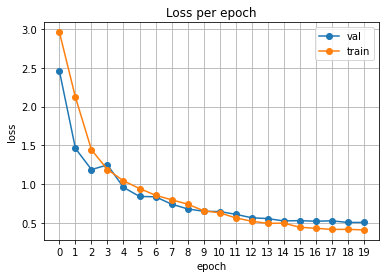

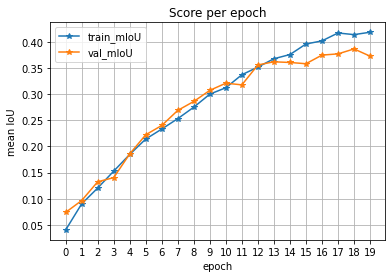

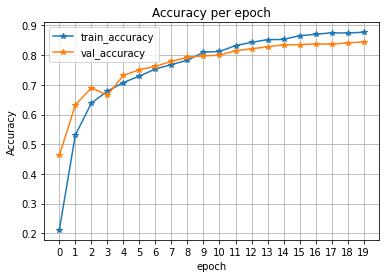

In [12]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [13]:
PATH = f"Unet-EfficientNet.bin"
torch.save(model.state_dict(), PATH)

# SegFormer Training

## Dataset Loaders

In [14]:
class DroneDatasetSegFormer(Dataset):
    def __init__(self, dataframe, feature_extractor):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, ix):
        row = self.dataframe.loc[ix].squeeze()
        image = Image.open(row['image'])        
        mask = Image.open(row['mask'])
        
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")
        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        
        return encoded_inputs

In [15]:
feature_extractor = SegformerFeatureExtractor(reduce_labels=True) # remove background class

train_set_segformer = DroneDatasetSegFormer(train, feature_extractor)
valid_dataset_segformer = DroneDatasetSegFormer(valid, feature_extractor)

train_dataloader = DataLoader(train_set_segformer, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset_segformer, batch_size=batch_size)

In [16]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0",
                                                         num_labels=num_classes+1, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.classifier.bias', 'decode_head.batch_norm.bias', 'decode_head.linear_c.3.pro

In [17]:
metric_train = load_metric("mean_iou")
metric_valid = load_metric("mean_iou")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
model.to(device)
print()

In [18]:
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []


for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        
        , logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_train.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 170 == 0:
            metrics = metric_train.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
            
    train_losses.append(loss.item())
    train_iou.append(metrics["mean_iou"])
    train_acc.append(metrics["mean_accuracy"])
            
    model.eval()
    print('-'*30, 'Validation', '-'*30)
    for idx, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_valid.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 19 == 0:
            metrics = metric_valid.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
    
    test_losses.append(loss.item())
    val_iou.append(metrics["mean_iou"])
    val_acc.append(metrics["mean_accuracy"])

Epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 3.1877808570861816
Mean_iou: 0.0049880320495405165
Mean accuracy: 0.028112313376372655
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 1.4657338857650757
Mean_iou: 0.19795061095956423
Mean accuracy: 0.2721020284693237
--------------------------------------------------
Epoch: 2


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.825817584991455
Mean_iou: 0.10368100696055717
Mean accuracy: 0.1716051324351948
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 1.0486397743225098
Mean_iou: 0.15176303662333926
Mean accuracy: 0.21816745553338715
--------------------------------------------------
Epoch: 3


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 1.2419077157974243
Mean_iou: 0.16711638726273456
Mean accuracy: 0.2294988566945575
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.869478166103363
Mean_iou: 0.19374955703220434
Mean accuracy: 0.25280347796374525
--------------------------------------------------
Epoch: 4


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9237934350967407
Mean_iou: 0.21602797409376712
Mean accuracy: 0.2765049687008384
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.718726634979248
Mean_iou: 0.25329126486259956
Mean accuracy: 0.3158904718863696
--------------------------------------------------
Epoch: 5


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.8599221706390381
Mean_iou: 0.2625711385355245
Mean accuracy: 0.32629179476417725
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.6108285188674927
Mean_iou: 0.29375363788585257
Mean accuracy: 0.3592095319049904
--------------------------------------------------
Epoch: 6


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.9463418126106262
Mean_iou: 0.3004655469333636
Mean accuracy: 0.36537395413515683
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.5708833932876587
Mean_iou: 0.3151796636985058
Mean accuracy: 0.3877370785545056
--------------------------------------------------
Epoch: 7


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.557960033416748
Mean_iou: 0.32269985336071366
Mean accuracy: 0.39158509306989725
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.5073533058166504
Mean_iou: 0.3483226864818553
Mean accuracy: 0.4207019811142944
--------------------------------------------------
Epoch: 8


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.6931954026222229
Mean_iou: 0.3557428714367031
Mean accuracy: 0.4267604491973042
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4673721492290497
Mean_iou: 0.379739940225654
Mean accuracy: 0.45062909052477346
--------------------------------------------------
Epoch: 9


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.717984139919281
Mean_iou: 0.3845053404836611
Mean accuracy: 0.4547722664473538
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.45219334959983826
Mean_iou: 0.3971036342532537
Mean accuracy: 0.4702453830711831
--------------------------------------------------
Epoch: 10


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.49494627118110657
Mean_iou: 0.40840744909414217
Mean accuracy: 0.48035873626789377
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.45819854736328125
Mean_iou: 0.40056067909964066
Mean accuracy: 0.4718006229937873
--------------------------------------------------
Epoch: 11


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.6299214959144592
Mean_iou: 0.41685655341915484
Mean accuracy: 0.4910570100177303
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4228336811065674
Mean_iou: 0.41230338817384043
Mean accuracy: 0.4849362829031589
--------------------------------------------------
Epoch: 12


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5481430888175964
Mean_iou: 0.43646267969803404
Mean accuracy: 0.5106324009152045
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.4077785611152649
Mean_iou: 0.4170668100954762
Mean accuracy: 0.4932844149430204
--------------------------------------------------
Epoch: 13


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.3787075877189636
Mean_iou: 0.4487204954928433
Mean accuracy: 0.5209737542621166
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3909316062927246
Mean_iou: 0.4292377299045971
Mean accuracy: 0.5069587840603454
--------------------------------------------------
Epoch: 14


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.4838126599788666
Mean_iou: 0.46676654341480844
Mean accuracy: 0.540422170658642
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3715439736843109
Mean_iou: 0.4444954314796972
Mean accuracy: 0.524487138191999
--------------------------------------------------
Epoch: 15


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.3692505955696106
Mean_iou: 0.4870597519548286
Mean accuracy: 0.5589135768740521
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.35899215936660767
Mean_iou: 0.4669127009004128
Mean accuracy: 0.5451345754455011
--------------------------------------------------
Epoch: 16


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.36193782091140747
Mean_iou: 0.5075407612442345
Mean accuracy: 0.5800678966968197
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.35316842794418335
Mean_iou: 0.47354056677836326
Mean accuracy: 0.550661307937507
--------------------------------------------------
Epoch: 17


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5336340665817261
Mean_iou: 0.5278375570478783
Mean accuracy: 0.6003816980562139
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.35198158025741577
Mean_iou: 0.4894721159924264
Mean accuracy: 0.5686229639272656
--------------------------------------------------
Epoch: 18


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.531893253326416
Mean_iou: 0.5422147803260624
Mean accuracy: 0.6171633830475262
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3403087854385376
Mean_iou: 0.4975883198268374
Mean accuracy: 0.5770661069939711
--------------------------------------------------
Epoch: 19


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.44489216804504395
Mean_iou: 0.5648759552632462
Mean accuracy: 0.6396674794622492
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3226337730884552
Mean_iou: 0.5126406296438591
Mean accuracy: 0.599243253445297
--------------------------------------------------
Epoch: 20


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5365480184555054
Mean_iou: 0.5694269892387841
Mean accuracy: 0.6456847210975641
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.32038480043411255
Mean_iou: 0.5255192934886778
Mean accuracy: 0.6109853543290611
--------------------------------------------------


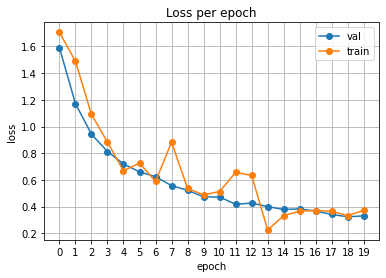

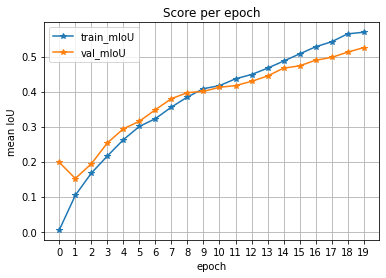

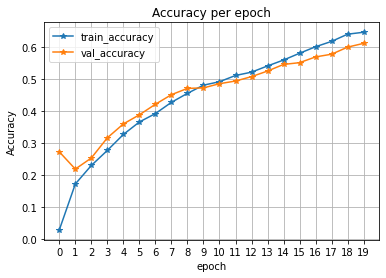

In [19]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc}

plot_loss(history)
plot_score(history)
plot_acc(history)

In [20]:
#last_model_wts = copy.deepcopy(model.state_dict())
PATH = f"SegFormer.bin"
torch.save(model.state_dict(), PATH)

# Models Evaluation

## Dataset loader

In [21]:
class DroneTestDataset(Dataset):
    
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
      
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.loc[idx].squeeze()
        img = cv2.imread(row['image'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(row['mask'], cv2.IMREAD_GRAYSCALE)
        color_mask = cv2.imread(row['color_mask'])
        color_mask = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask, color_mask


t_test = A.Resize(512, 512, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(test, transform=t_test)

In [22]:
def predict_image_mask_miou_unet(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [23]:
@torch.no_grad()
def predict_image_mask_miou_segformer(model, image, mask):
    metric_test = load_metric("mean_iou")
    model.eval()
    
    encoding = feature_extractor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(device)
    
    outputs = model(pixel_values=pixel_values)
    logits = outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(logits,
                                                 size=image.size[::-1],
                                                 mode='bilinear',
                                                 align_corners=False)
    seg = upsampled_logits.argmax(dim=1)[0]
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    
    np_palette = np.array(palette)
    for label, color in enumerate(np_palette):
        color_seg[seg == label, :] = color
        
    color_seg = color_seg[..., ::-1]

    img = np.array(image)
    img = img.astype(np.uint8)
    
    # GT
    gt_map = np.array(mask)
    gt_map[gt_map == 0] = 255
    gt_map = gt_map - 1
    gt_map[gt_map == 254] = 255

    classes_map = np.unique(gt_map).tolist()
    unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]

    color_seg = np.zeros((gt_map.shape[0], gt_map.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(np_palette):
        color_seg[gt_map == label, :] = color

    color_seg = color_seg[..., ::-1]
    
    return seg, metrics["mean_iou"]

## Load models

In [24]:
PATH_SEGFORMER = f"./SegFormer.bin"


def load_model_segformer(path):
    #model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

segformer = load_model_segformer(PATH_SEGFORMER)

In [25]:
PATH_UNET = f"./Unet-EfficientNet.bin"

def build_model_Unet():
    model = smp.Unet(
        'efficientnet-b0', encoder_weights=None, classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16]
    )
    model.to(device)
    return model

def load_model_Unet(path):
    model = build_model_Unet()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

unet = load_model_Unet(PATH_UNET)

In [26]:
mean_iou_unet = []
mean_iou_segformer = []
for i in range(len(test_set)):
    image, mask, color_mask = test_set[i]
    pred_mask, score = predict_image_mask_miou_unet(unet, image, mask)
    mean_iou_unet.append(score)
    pred_mask, score = predict_image_mask_miou_segformer(segformer, image, mask)
    mean_iou_segformer.append(score)
    
test_average_iou_unet = np.mean(mean_iou_unet)
test_average_iou_segformer =np.mean(mean_iou_segformer)

print("Averaged mean IoU test set: \n")
print("U-Net: ", test_average_iou_unet)
print("SegFormer", test_average_iou_segformer)

Averaged mean IoU test set: 

U-Net:  0.395576581180799
SegFormer 0.5255192934886778


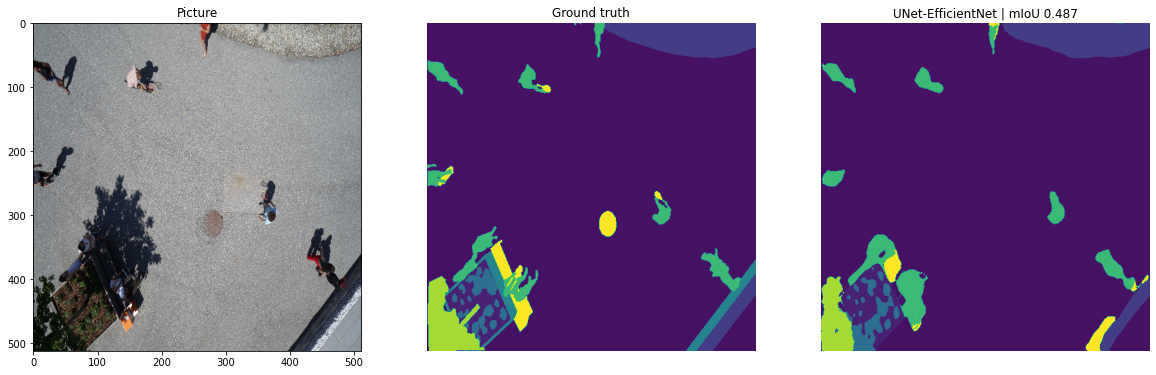

In [32]:
image, mask, color_mask = test_set[7]
pred_mask, score = predict_image_mask_miou_unet(unet, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-EfficientNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

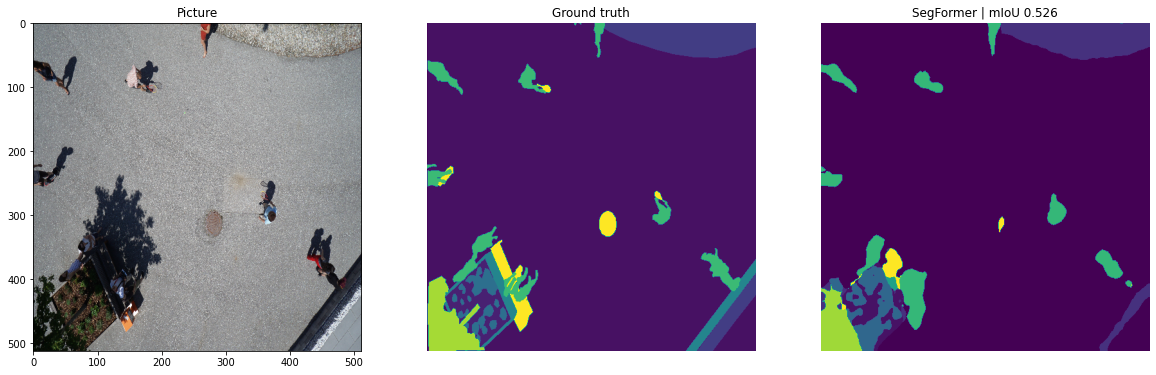

In [33]:
image, mask, cmask = test_set[7]
pred_mask, score = predict_image_mask_miou_segformer(segformer, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('SegFormer | mIoU {:.3f}'.format(score))
ax3.set_axis_off()